<a href="https://colab.research.google.com/github/SnehaDharne/OcularDiseaseRecognition/blob/main/hyp_resnet50_mirnet_msr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import os

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [ ]:
pip install keras_tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 5.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
df_path = '/content/drive/MyDrive/ODIR-5K/balanced_dataset_filled.csv'
df = pd.read_csv(df_path)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, preprocessing
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import Callback
import keras_tuner
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from keras_tuner import Hyperband
from sklearn.metrics import f1_score, roc_auc_score
from tensorflow.keras.metrics import AUC
from keras.preprocessing.image import ImageDataGenerator

# Define custom callback for evaluating metrics
class MetricsCallback(Callback):
    def __init__(self, validation_data):
        super(MetricsCallback, self).__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        x_val, y_val = self.validation_data
        y_pred = self.model.predict(x_val)
        y_pred_binary = (y_pred > 0.5).astype(int)  # Binary predictions for calculating F1 score
        f1 = f1_score(y_val, y_pred_binary)
        auc = roc_auc_score(y_val, y_pred)
        logs['val_f1'] = f1
        logs['val_auc'] = auc

# Define the function to build the model
def build_model(hp):
    # Load the ResNet50 base model
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the base model layers
    base_model.trainable = False

    # Create the top layers
    top_model = Sequential()
    top_model.add(base_model)
    # top_model.add(GlobalAveragePooling2D())
    top_model.add(Flatten())
    # Define the hyperparameters to tune
    num_layers = hp.Int('num_layers', min_value=3, max_value=4, step=1)
    num_neurons = hp.Int('num_neurons', min_value=128, max_value=512, step=128)

    for _ in range(num_layers):
        top_model.add(Dense(num_neurons, activation='relu'))

    top_model.add(Dense(8, activation='sigmoid'))

    # Combine the base and top layers
    # model = Sequential([base_model, top_model])

    # Compile the model
    top_model.compile(optimizer='adam', loss='binary_crossentropy',metrics=[AUC(name='auc')])

    return top_model


# Create the tuner
tuner2= keras_tuner.tuners.Hyperband(
    build_model,
    objective=keras_tuner.Objective("auc", direction="max"),  # Use F1 score as the objective to optimize
    max_epochs=10,
)

data_dir_preprocessed = '/content/drive/MyDrive/ODIR-5K/clahe+mirnet'  # Replace with the path to your preprocessed images
test_image_dir = '/content/drive/MyDrive/ODIR-5K/test-clahe-mirnet'  # Replace with the path to your test images
df['filename'] = ""
df['filename'] = df.apply(lambda row: os.path.join(data_dir_preprocessed, str('clahe_mirnet_'+row['ID'])), axis=1)
batch_size = 64
epochs = 10

# Create an ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True)

# Load the training and validation data
 # Replace with the path to your training data file
train_set = df.sample(frac=0.8, random_state=42)
val_set = df.drop(train_set.index)

# Create the flow from dataframe for training and validation sets
train_generator2 = train_datagen.flow_from_dataframe(dataframe=train_set,
                                                    directory=data_dir_preprocessed,
                                                    x_col="filename",
                                                    y_col=["Normal", "Diabetes", "Glaucoma", "Cataract",
                                                           "AMD", "Hypertension", "Myopia", "Others"],
                                                    target_size=(224, 224),
                                                    batch_size=batch_size,
                                                    class_mode="raw",
                                                    shuffle=True)

val_generator2 = train_datagen.flow_from_dataframe(dataframe=val_set,
                                                  directory=data_dir_preprocessed,
                                                  x_col="filename",
                                                  y_col=["Normal", "Diabetes", "Glaucoma", "Cataract",
                                                         "AMD", "Hypertension", "Myopia", "Others"],
                                                  target_size=(224, 224),
                                                  batch_size=batch_size,
                                                  class_mode="raw",
                                                  shuffle=False)

# Perform the hyperparameter search
print('everythin is alright')

# model.fit(train_generator, epochs=10, validation_data=val_generator)
# Perform the hyperparameter search
tuner2.search(train_generator2, epochs=10, validation_data=val_generator2)

# Retrieve the best hyperparameters and build the final model
best_hps2 = tuner2.get_best_hyperparameters(num_trials=1)[0]


Trial 8 Complete [00h 06m 06s]
auc: 0.756191611289978

Best auc So Far: 0.7618303894996643
Total elapsed time: 01h 17m 16s


NameError: ignored

In [ ]:
model2 = tuner2.hypermodel.build(best_hps2)
model2.summary()
print(f"""
The hyperparameter search is complete. The optimal number of layers r is {best_hps2.get('num_layers')} and the optimal learning rate for the optimizer number of neurons
is {best_hps2.get('num_neurons')}.
""")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_5 (Dense)             (None, 512)               51380736  
                                                                 
 dense_6 (Dense)             (None, 512)               262656    
                                                                 
 dense_7 (Dense)             (None, 512)               262656    
                                                                 
 dense_8 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 75,497,864
Trainable params: 51,910,152


In [ ]:
tuner2.search(train_generator2, epochs=10, validation_data=val_generator2)

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Create the top layers
top_model = Sequential()
top_model.add(Flatten())

top_model.add(Dense(512, activation='relu'))
top_model.add(Dense(512, activation='relu'))
top_model.add(Dense(512, activation='relu'))

top_model.add(Dense(8, activation='sigmoid'))

# Combine the base and top layers
model = Sequential([base_model, top_model])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=[AUC(name='auc')])
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 sequential_17 (Sequential)  (None, 8)                 51910152  
                                                                 
Total params: 75,497,864
Trainable params: 51,910,152
Non-trainable params: 23,587,712
_________________________________________________________________


The choice between using `flatten()` or `gap()` as the top layer of a pretrained ResNet50 model depends on the specific task you are trying to accomplish.

1. Flatten Layer: The `flatten()` layer converts the input tensor into a 1-dimensional tensor, which is useful when you want to feed the output of the ResNet50 model into a fully connected (dense) layer. If your task requires a fully connected layer or some other type of classifier, then using `flatten()` would be appropriate. For example, if you want to perform image classification on a specific dataset, you can add a `flatten()` layer followed by a dense layer with the appropriate number of units for the number of classes in your dataset.

2. Global Average Pooling Layer: The `gap()` (global average pooling) layer calculates the average value for each feature map of the input tensor, resulting in a fixed-length feature vector regardless of the input image's spatial dimensions. Global average pooling is commonly used in transfer learning scenarios, as it helps in aggregating spatial information while significantly reducing the number of parameters. It can be effective when you want to extract features from the ResNet50 model and use them as input for another classifier, such as a support vector machine (SVM) or a fully connected layer.

In summary, if you plan to add a dense layer or a classifier on top of the ResNet50 model, use `flatten()`. If you want to extract features and use them for another classifier, `gap()` can be a suitable choice.

In [ ]:
import matplotlib.pyplot as plt
history = model.fit(train_generator, epochs=10, validation_data=val_generator)

# Print the history values
for metric in history.history:
    print(metric, history.history[metric])


Epoch 1/10
129/129 [==============================] - 161s 1s/step - loss: 0.5188 - auc: 0.6416 - val_loss: 0.3653 - val_auc: 0.7416
Epoch 2/10
129/129 [==============================] - 155s 1s/step - loss: 0.3561 - auc: 0.7523 - val_loss: 0.3487 - val_auc: 0.7783
Epoch 3/10
129/129 [==============================] - 154s 1s/step - loss: 0.3442 - auc: 0.7779 - val_loss: 0.3585 - val_auc: 0.7684
Epoch 4/10
129/129 [==============================] - 154s 1s/step - loss: 0.3412 - auc: 0.7847 - val_loss: 0.3329 - val_auc: 0.8050
Epoch 5/10
129/129 [==============================] - 155s 1s/step - loss: 0.3338 - auc: 0.7977 - val_loss: 0.3478 - val_auc: 0.7763
Epoch 6/10
129/129 [==============================] - 154s 1s/step - loss: 0.3267 - auc: 0.8090 - val_loss: 0.3375 - val_auc: 0.7916
Epoch 7/10
129/129 [==============================] - 154s 1s/step - loss: 0.3277 - auc: 0.8068 - val_loss: 0.3293 - val_auc: 0.8111
Epoch 8/10
129/129 [==============================] - 153s 1s/step - 

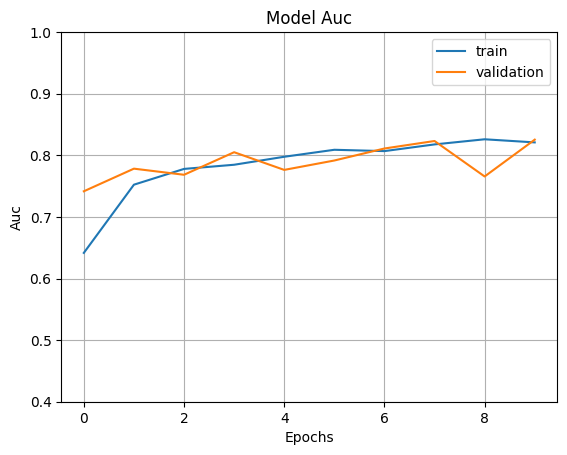

In [ ]:


fig1 = plt.gcf()
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Auc')
plt.ylabel('Auc')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()


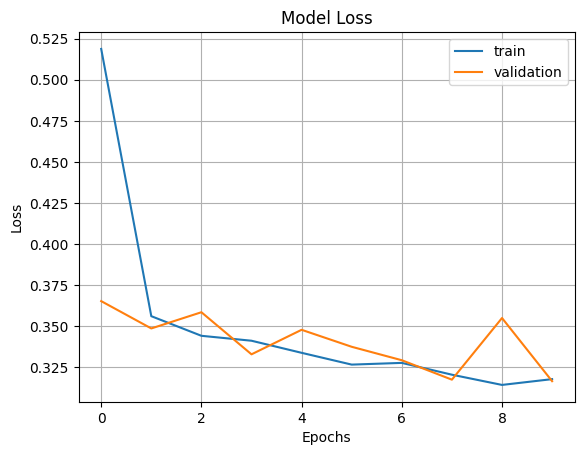

In [ ]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
import os
import glob
import numpy as np
# Get the list of image file paths in the test set
test_image_paths = glob.glob(os.path.join(test_image_dir, "*.jpg"))

# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=["filename", "N", "D", "G", "C",
                                   "A", "H", "M", "O"])

# Load and preprocess each test image
for image_path in test_image_paths:
    filename = os.path.basename(image_path)
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    # Make predictions for the image
    predictions = model.predict(img)

    # Create a new row for the results DataFrame
    result_row = {"filename": filename}
    for i, class_name in enumerate(["N", "D", "G", "C",
                                    "A", "H", "M", "O"]):
        result_row[class_name] = predictions[0][i]

    # Append the result row to the DataFrame
    results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 2s 2s/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 41ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 42ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 38ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 42ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 38ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 41ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 41ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 43ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 38ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 44ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 51ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 41ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 46ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 43ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 39ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 41ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 51ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 39ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 41ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 39ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 39ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 43ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 38ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 57ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 38ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 39ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 38ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 41ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 41ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 38ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 38ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 39ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 43ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 39ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 39ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 39ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-18-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


In [ ]:
import pandas as pd

# Assuming your DataFrame is named 'df'
df = results_df[~results_df['filename'].str.contains('\(1\)')]

# Display the filtered DataFrame
print(df)


# Sum the probabilities along the row axis
probs = df.iloc[:, 1:].sum(axis=1)

# Display the updated DataFrame
print(probs)

# Step 1: Create 'id' column from filename
df['id'] = df['filename'].str.split('_').str[0]

# Step 2: Remove 'filename' and 'side' columns
df = df.drop(['filename'], axis=1)
grouped_df = df.groupby('id').agg({'N': 'min', 'D': 'max', 'G': 'max', 'C': 'max',
                                   'A': 'max', 'H': 'max', 'M': 'max', 'O': 'max'})

# Display the modified DataFrame
print(grouped_df)

grouped_df.to_csv('hyp-mirnet-r50-bal.csv')

            filename         N         D         G         C         A  \
0      1044_left.jpg  0.307657  0.355623  0.050916  0.000889  0.074119   
1      1051_left.jpg  0.343211  0.320537  0.051285  0.001501  0.079796   
2      1076_left.jpg  0.271830  0.358291  0.076042  0.001650  0.084189   
3      1037_left.jpg  0.371330  0.306747  0.052724  0.004014  0.044737   
4      1055_left.jpg  0.064661  0.200868  0.132630  0.000268  0.140321   
...              ...       ...       ...       ...       ...       ...   
1004   1073_left.jpg  0.032673  0.092001  0.106780  0.000018  0.023004   
1005  1055_right.jpg  0.132528  0.302425  0.108263  0.000316  0.141337   
1006   1069_left.jpg  0.400715  0.313325  0.004037  0.000083  0.014821   
1007   1029_left.jpg  0.360731  0.293402  0.036007  0.001075  0.039198   
1008   1049_left.jpg  0.308621  0.374808  0.023299  0.000350  0.053883   

             H         M         O  
0     0.132559  0.002103  0.292619  
1     0.191344  0.005994  0.185102  


<ipython-input-19-0153958f5452>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['id'] = df['filename'].str.split('_').str[0]


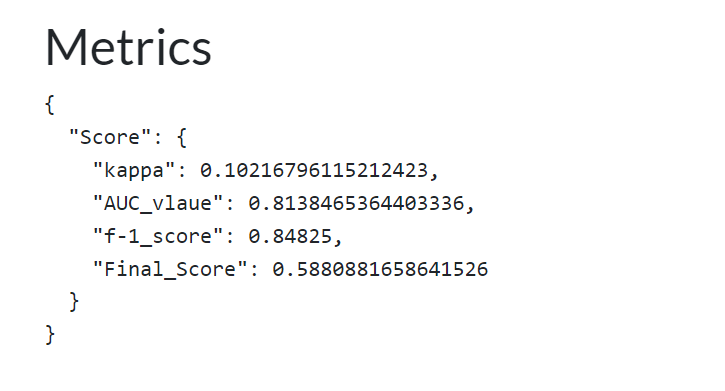

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 sequential_4 (Sequential)   (None, 8)                 9932936   
                                                                 
Total params: 24,647,624
Trainable params: 9,932,936
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
data_dir_preprocessed = '/content/drive/MyDrive/archive/ODIR-5K/ODIR-5K/clahe+msr'  # Replace with the path to your preprocessed images
test_image_dir = '/content/drive/MyDrive/archive/test-clahe-msr'  # Replace with the path to your test images
import pandas as pd
df_path = '/content/drive/MyDrive/ODIR-5K/balanced_dataset_filled.csv'
df = pd.read_csv(df_path)
df['filename'] = ""
df['filename'] = df.apply(lambda row: os.path.join(data_dir_preprocessed, str(row['ID'])), axis=1)
batch_size = 64
epochs = 10

# Create an ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True)

# Load the training and validation data
 # Replace with the path to your training data file
train_set = df.sample(frac=0.8, random_state=42)
val_set = df.drop(train_set.index)

# Create the flow from dataframe for training and validation sets
train_generator = train_datagen.flow_from_dataframe(dataframe=train_set,
                                                    directory=data_dir_preprocessed,
                                                    x_col="filename",
                                                    y_col=["Normal", "Diabetes", "Glaucoma", "Cataract",
                                                           "AMD", "Hypertension", "Myopia", "Others"],
                                                    target_size=(224, 224),
                                                    batch_size=batch_size,
                                                    class_mode="raw",
                                                    shuffle=True)

val_generator = train_datagen.flow_from_dataframe(dataframe=val_set,
                                                  directory=data_dir_preprocessed,
                                                  x_col="filename",
                                                  y_col=["Normal", "Diabetes", "Glaucoma", "Cataract",
                                                         "AMD", "Hypertension", "Myopia", "Others"],
                                                  target_size=(224, 224),
                                                  batch_size=batch_size,
                                                  class_mode="raw",
                                                  shuffle=False)


Found 8249 validated image filenames.
Found 2062 validated image filenames.


In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Create the top layers
top_model = Sequential()
top_model.add(Flatten())

top_model.add(Dense(512, activation='relu'))
top_model.add(Dense(512, activation='relu'))
top_model.add(Dense(512, activation='relu'))

top_model.add(Dense(8, activation='sigmoid'))

# Combine the base and top layers
model5 = Sequential([base_model, top_model])

# Compile the model
model5.compile(optimizer='adam', loss='binary_crossentropy',metrics=[AUC(name='auc')])
model5.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 sequential_2 (Sequential)   (None, 8)                 51910152  
                                                                 
Total params: 75,497,864
Trainable params: 51,910,152
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
import matplotlib.pyplot as plt
history1 = model5.fit(train_generator, epochs=10, validation_data=val_generator)



Epoch 1/10
129/129 [==============================] - 1501s 12s/step - loss: 0.5360 - auc: 0.6038 - val_loss: 0.3858 - val_auc: 0.6908
Epoch 2/10
129/129 [==============================] - 159s 1s/step - loss: 0.3812 - auc: 0.6943 - val_loss: 0.3813 - val_auc: 0.6977
Epoch 3/10
129/129 [==============================] - 159s 1s/step - loss: 0.3741 - auc: 0.7120 - val_loss: 0.3657 - val_auc: 0.7447
Epoch 4/10
129/129 [==============================] - 162s 1s/step - loss: 0.3668 - auc: 0.7308 - val_loss: 0.3875 - val_auc: 0.6655
Epoch 5/10
129/129 [==============================] - 167s 1s/step - loss: 0.3647 - auc: 0.7366 - val_loss: 0.3690 - val_auc: 0.7319
Epoch 6/10
129/129 [==============================] - 164s 1s/step - loss: 0.3588 - auc: 0.7491 - val_loss: 0.3533 - val_auc: 0.7623
Epoch 7/10
129/129 [==============================] - 163s 1s/step - loss: 0.3555 - auc: 0.7561 - val_loss: 0.3546 - val_auc: 0.7594
Epoch 8/10
129/129 [==============================] - 168s 1s/step 

NameError: ignored

In [ ]:
# Print the history values
for metric1 in history1.history:
    print(metric1, history1.history[metric1])

loss [0.5360140204429626, 0.3812016248703003, 0.37411201000213623, 0.3668425679206848, 0.3646595776081085, 0.3587971329689026, 0.3554961085319519, 0.3521806001663208, 0.34983569383621216, 0.3473204970359802]
auc [0.6037558913230896, 0.6942529082298279, 0.7119855880737305, 0.7308250665664673, 0.7366012930870056, 0.749136209487915, 0.7561265230178833, 0.7639275789260864, 0.7685906291007996, 0.7728123068809509]
val_loss [0.3858470916748047, 0.38132116198539734, 0.365708589553833, 0.38747936487197876, 0.3689839541912079, 0.3532715439796448, 0.3545549809932709, 0.34581974148750305, 0.3465704321861267, 0.3434777855873108]
val_auc [0.6908105611801147, 0.6976909041404724, 0.7447156310081482, 0.6654742360115051, 0.7319310903549194, 0.7623196840286255, 0.7593689560890198, 0.7775939106941223, 0.7757947444915771, 0.7838316559791565]


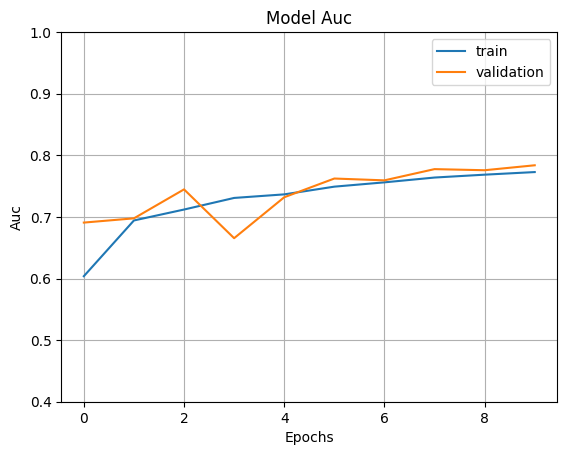

In [ ]:


fig1 = plt.gcf()
plt.plot(history1.history['auc'])
plt.plot(history1.history['val_auc'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Auc')
plt.ylabel('Auc')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()


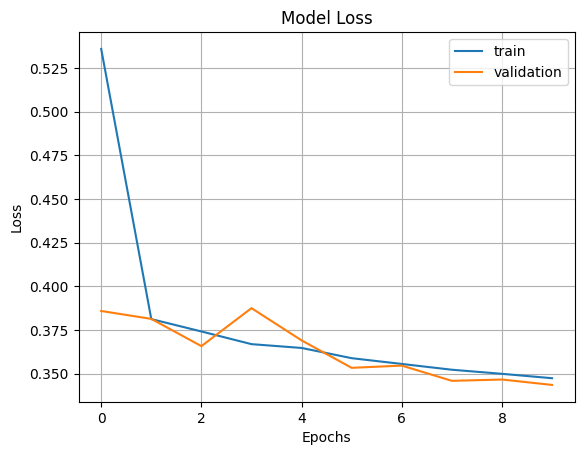

In [ ]:

plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()


In [ ]:
import os
import glob
import numpy as np
# Get the list of image file paths in the test set
test_image_paths = glob.glob(os.path.join(test_image_dir, "*.jpg"))

# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=["filename", "N", "D", "G", "C",
                                   "A", "H", "M", "O"])

# Load and preprocess each test image
for image_path in test_image_paths:
    filename = os.path.basename(image_path)
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    # Make predictions for the image
    predictions = model.predict(img)

    # Create a new row for the results DataFrame
    result_row = {"filename": filename}
    for i, class_name in enumerate(["N", "D", "G", "C",
                                    "A", "H", "M", "O"]):
        result_row[class_name] = predictions[0][i]

    # Append the result row to the DataFrame
    results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 73ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 38ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 39ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 41ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 38ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 40ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 47ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 38ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 38ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 42ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 39ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 42ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 48ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 38ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 46ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 41ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 38ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 48ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 41ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 39ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 43ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 38ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 52ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 41ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 40ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 38ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 50ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 38ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 38ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 41ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 40ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-25-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


In [ ]:
import pandas as pd

# Assuming your DataFrame is named 'df'
df = results_df[~results_df['filename'].str.contains('\(1\)')]

# Display the filtered DataFrame
print(df)


# Sum the probabilities along the row axis
probs = df.iloc[:, 1:].sum(axis=1)

# Display the updated DataFrame
print(probs)

# Step 1: Create 'id' column from filename
df['id'] = df['filename'].str.split('_').str[0]

# Step 2: Remove 'filename' and 'side' columns
df = df.drop(['filename'], axis=1)
grouped_df = df.groupby('id').agg({'N': 'min', 'D': 'max', 'G': 'max', 'C': 'max',
                                   'A': 'max', 'H': 'max', 'M': 'max', 'O': 'max'})

# Display the modified DataFrame
print(grouped_df)

grouped_df.to_csv('hyp-msr-r50-bal.csv')

            filename         N         D         G         C         A  \
0      1051_left.jpg  0.344396  0.304923  0.133070  0.008665  0.081663   
1      1076_left.jpg  0.339831  0.288884  0.154380  0.128916  0.040148   
2      1037_left.jpg  0.357046  0.296452  0.091752  0.098136  0.030755   
3      1055_left.jpg  0.288747  0.318364  0.181315  0.015621  0.071015   
4     1027_right.jpg  0.372672  0.298875  0.077735  0.009164  0.056185   
...              ...       ...       ...       ...       ...       ...   
1004  1055_right.jpg  0.252266  0.284343  0.203096  0.006845  0.046521   
1005   1069_left.jpg  0.371489  0.317946  0.049786  0.001467  0.060350   
1006   1029_left.jpg  0.436309  0.250394  0.035856  0.016258  0.026334   
1007   1049_left.jpg  0.404053  0.293079  0.089036  0.024147  0.038355   
1008   1044_left.jpg  0.369152  0.296980  0.095985  0.066429  0.057086   

             H         M         O  
0     0.118137  0.020372  0.276720  
1     0.040465  0.038715  0.306589  


<ipython-input-26-51a96a52ac23>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['id'] = df['filename'].str.split('_').str[0]


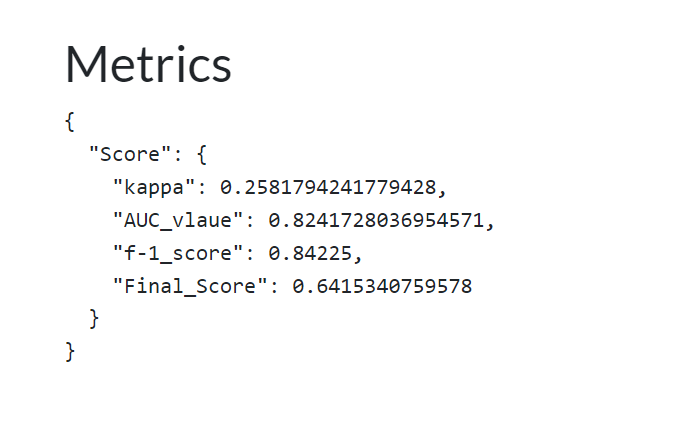